# Analyze evolution of movies genres in different countries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Load dataset metadata
metadata_columns = [
    'Wikipedia_movie_ID', 
    'Freebase_movie_ID', 
    'Movie_name', 
    'Movie_release_date', 
    'Movie_box_office_revenue', 
    'Movie_runtime', 
    'Movie_languages', 
    'Movie_countries', 
    'Movie_genres'
]

path_to_data = '../data/MovieSummaries/'
df_metadata = pd.read_csv(path_to_data + 'movie.metadata.tsv', delimiter='\t', names=metadata_columns)

In [3]:
# Format movie languages, countries and genres
def remove_id(original_str):
    if pd.isna(original_str) or original_str == '{}':
        return [] # if NaN, return empty list
    
    original_elems = original_str.strip('{}').split(',')
    new_elems = [elem.split(':', 1)[1].strip().strip('"') for elem in original_elems if ':' in elem]
    return new_elems

In [4]:
df_metadata['Movie_languages'] = df_metadata['Movie_languages'].apply(remove_id)
df_metadata['Movie_countries'] = df_metadata['Movie_countries'].apply(remove_id)
df_metadata['Movie_genres'] = df_metadata['Movie_genres'].apply(remove_id)

In [5]:
# Keep only the years in the movie release date

# Could not make it work with datetime:
# 1. pd.to_datetime(df_metadata['Movie_release_date'])
# 2. df_metadata['Movie_release_date'].dt.year

# [TODO] check all dates are in the format YYYY first

df_metadata['Movie_release_date'] = df_metadata['Movie_release_date'].str.slice(0,4)

# [CHECK] all values are either integers or NaN (no 18-0 for example)
# is_all_integers = df_metadata['Movie_release_date'].apply(lambda year: pd.isna(year) or str(year).isdigit()).all()
# print("All elements are either integers or missing:", is_all_integers)

In [6]:
df_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [7]:
# All countries in the dataset
all_countries = set(country for countries in df_metadata['Movie_countries'].dropna() for country in countries)
all_countries = sorted(all_countries)

print("List of all unique countries:")
print(all_countries)

List of all unique countries:
['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burma', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', 'Crime', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czechoslovakia', 'Democratic Republic of the Congo', 'Denmark', 'Egypt', 'England', 'Estonia', 'Ethiopia', 'Federal Republic of Yugoslavia', 'Finland', 'France', 'Georgia', 'Georgian SSR', 'German Democratic Republic', 'German Language', 'Germany', 'Greece', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Iraqi Kurdistan', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kenya', 'Kingdom of Great Britain', 'Kingdom of Italy', 'Korea', 'Kuwait', 'Lebanon', 'Libya', 'Lithuania', 'Luxe

#### Some problems with the countries
1. Ukrainian SSR and Ukranian SSR are two different categories: should merge them as one
2. German Language? Malayalam Language? Is it related to the country or is it only the language (mistake)?
3. Should we merge Kingdom of Italy with Italy? Or should we do a category for former countries?
4. 'Crime' country?
5. South Korea and Korea?

In [8]:
# Approximate continents with all countries
north_america = ['Aruba', 'Bahamas', 'Canada', 'Costa Rica', 'Cuba', 'Jamaica', 'Mexico', 
                 'Panama', 'Puerto Rico', 'United States of America']

south_america = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Peru', 'Uruguay', 'Venezuela']

europe = ['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belgium', 'Bosnia and Herzegovina','Bulgaria', 
          'Croatia', 'Cyprus', 'Czech Republic', 'Czechoslovakia', 'Denmark', 'England', 'Estonia', 
          'Federal Republic of Yugoslavia', 'Finland', 'France', 'Georgia', 'Georgian SSR', 
          'German Democratic Republic', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 
          'Italy', 'Kingdom of Great Britain', 'Kingdom of Italy', 'Lithuania', 'Luxembourg', 'Malta', 
          'Monaco', 'Montenegro', 'Nazi Germany', 'Netherlands', 'Northern Ireland', 'Norway', 'Poland', 'Portugal', 
          'Republic of Macedonia', 'Romania', 'Russia', 'Scotland', 'Serbia', 'Serbia and Montenegro', 
          'Slovak Republic', 'Slovakia', 'Slovenia', 'Socialist Federal Republic of Yugoslavia', 'Spain', 
          'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'Wales', 'Weimar Republic', 'West Germany', 
          'Yugoslavia']

asia = ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Burma', 'Cambodia', 'China', 
        'Georgia', 'Hong Kong', 'India', 'Indonesia', 'Iran', 'Iraq', 'Iraqi Kurdistan', 'Israel', 'Japan', 
        'Jordan', 'Kazakhstan', 'Korea', 'Kuwait', 'Lebanon', 'Macau', 'Malaysia', 'Mongolia', 'Nepal', 'Pakistan',
        'Palestinian Territories', 'Palestinian territories', 'Philippines', 'Qatar', 'Republic of China', 
        'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Taiwan', 'Thailand', 'Turkey', 
        'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam']


africa = ['Algeria', 'Burkina Faso', 'Cameroon', 'Congo', 'Democratic Republic of the Congo', 'Egypt', 
          'Ethiopia', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Libya', 'Mali', 'Morocco', 'Nigeria', 'Senegal', 
          'South Africa', 'Sudan', 'Tunisia', 'Zambia', 'Zimbabwe']


middle_east = ['Bahrain', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Mandatory Palestine', 
               'Qatar', 'Saudi Arabia', 'Syria', 'Turkey', 'United Arab Emirates', 'Yemen']

oceania = ['Australia', 'New Zealand']

former_states_regions = ['Soviet Union', 'Soviet occupation zone', 'Ukrainian SSR', 'Uzbek SSR']

In [9]:
# Analyze distribution genres wrt year (every 10 years) and countries

df_metadata['Movie_release_date'] = pd.to_numeric(df_metadata['Movie_release_date'], errors='coerce')
df_metadata['Decade'] = (df_metadata['Movie_release_date'].dropna() // 10 * 10).astype('Int64')

# Assign each movie to a continent
def get_continent(country):
    if country in north_america:
        return 'North America'
    elif country in south_america:
        return 'South America'
    elif country in europe:
        return 'Europe'
    elif country in asia:
        return 'Asia'
    elif country in africa:
        return 'Africa'
    elif country in middle_east:
        return 'Middle East'
    elif country in oceania:
        return 'Oceania'
    else:
        return 'Unknown'   # If country forgotten or invalid

df_metadata['Movie_continent'] = df_metadata['Movie_countries'].apply(lambda countries: get_continent(countries[0]) 
                                                                if isinstance(countries, list) and countries else 'Unknown')

# Explode genres into separate rows
df_metadata['Movie_genres'] = df_metadata['Movie_genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
df_metadata_exploded = df_metadata.explode('Movie_genres')

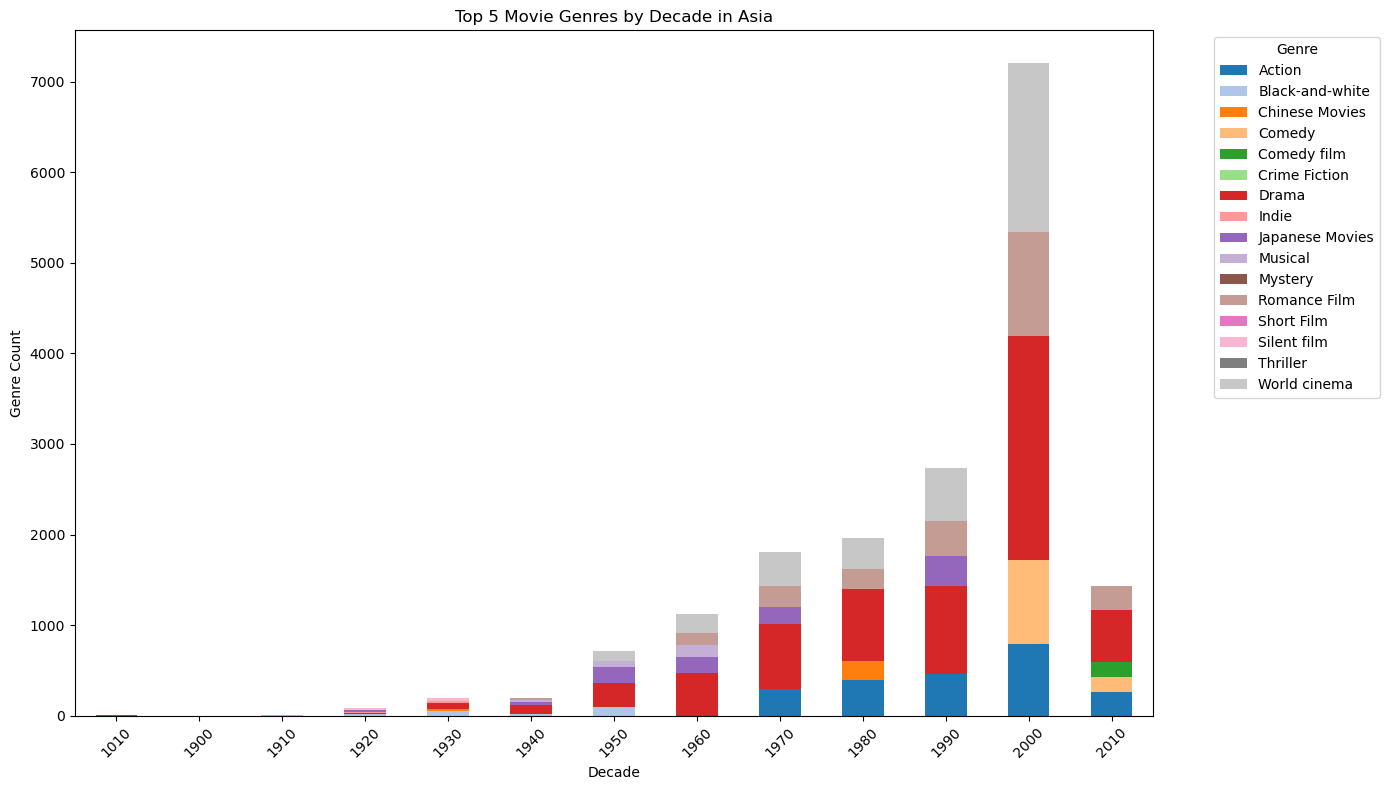

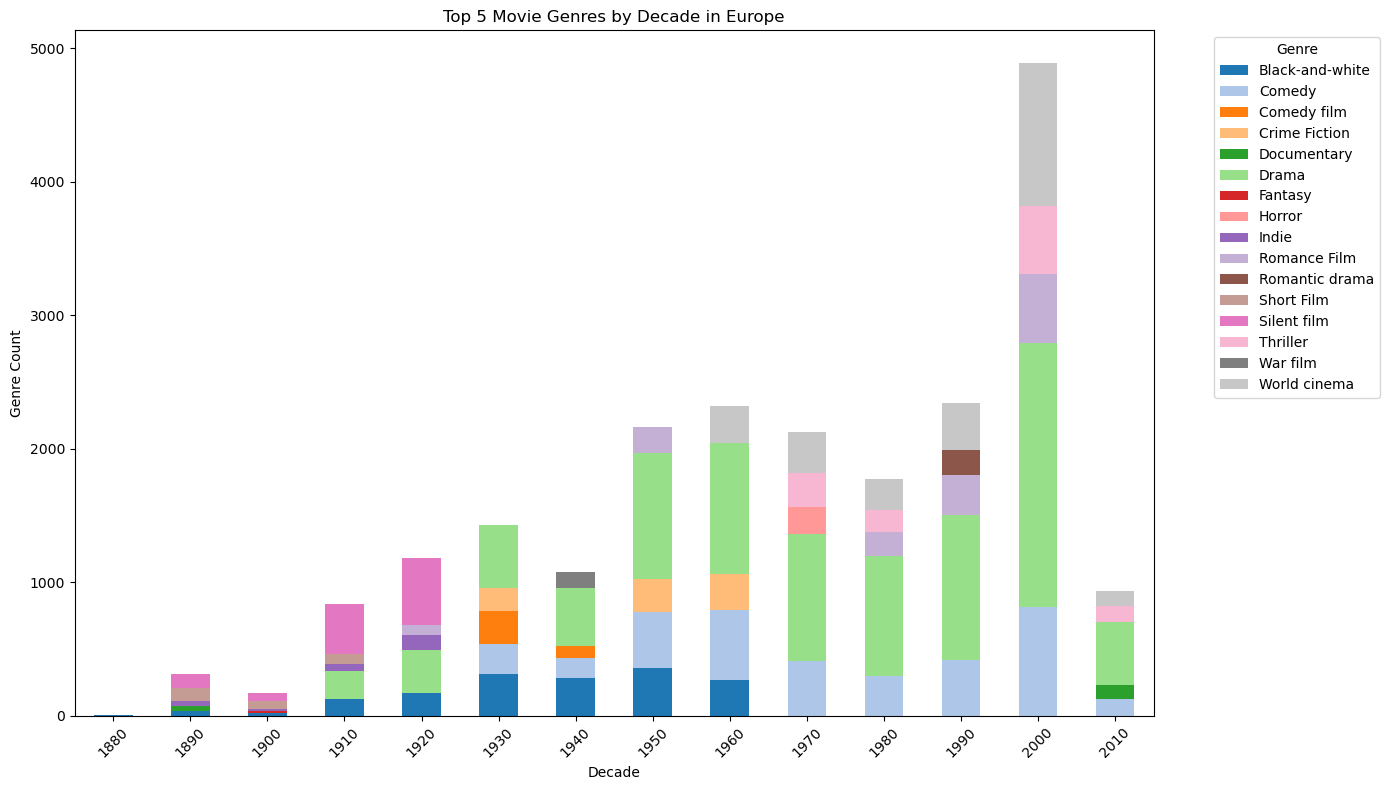

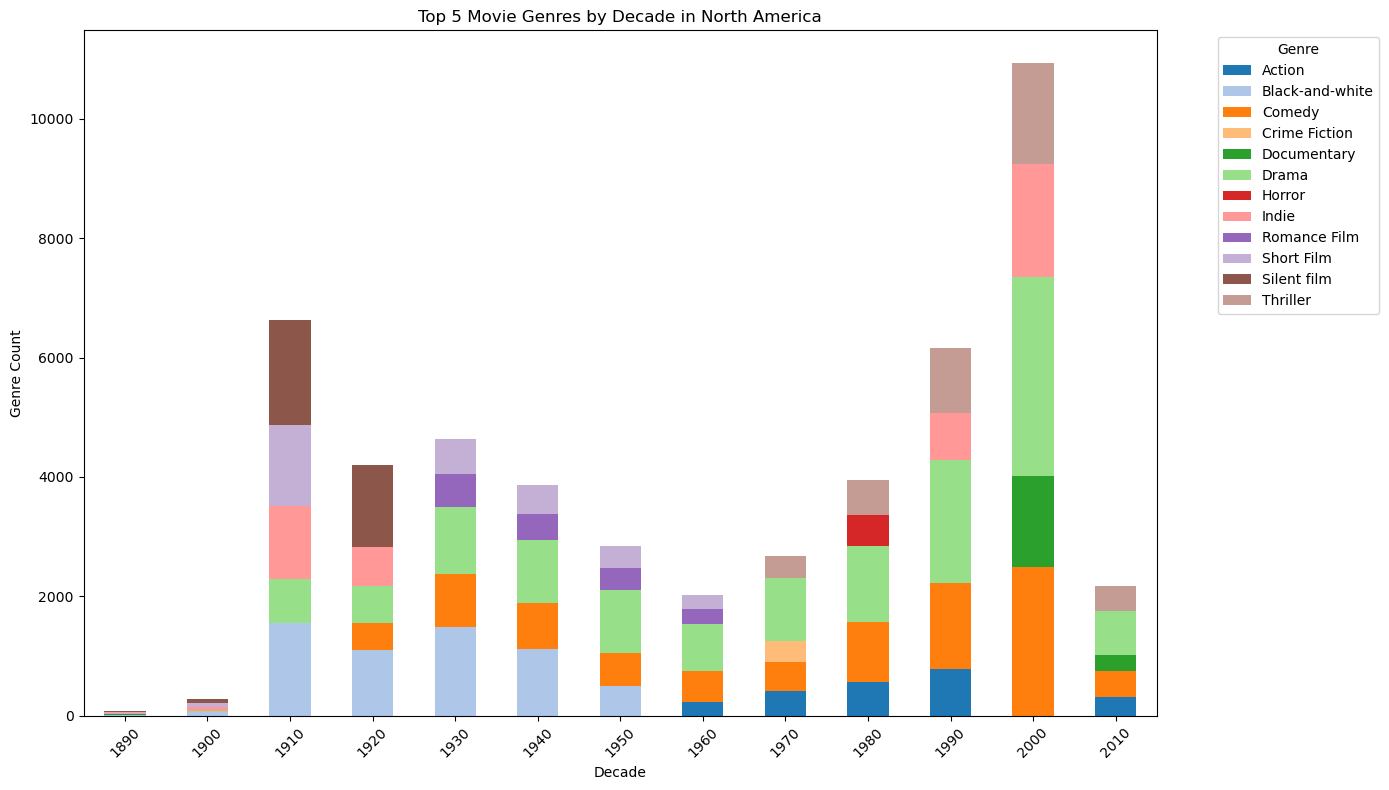

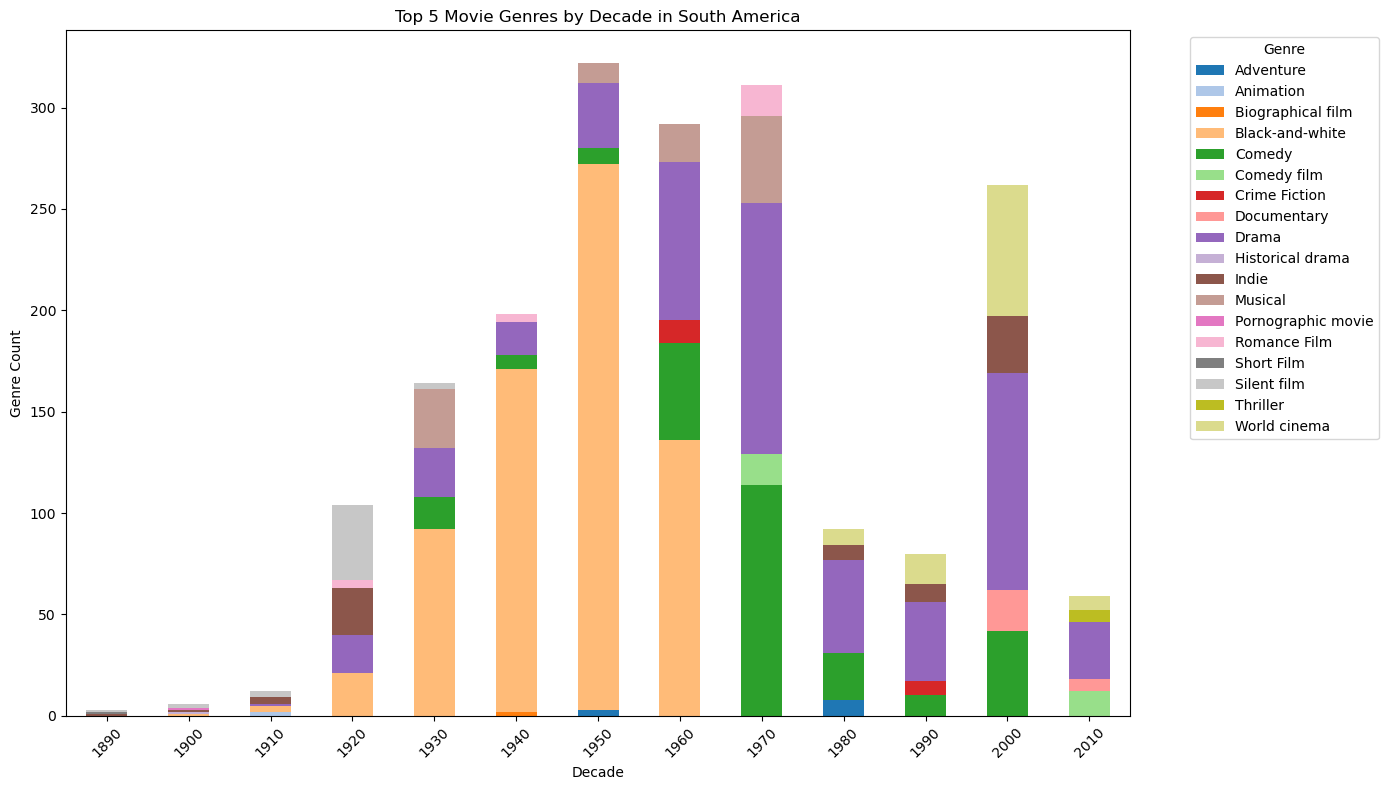

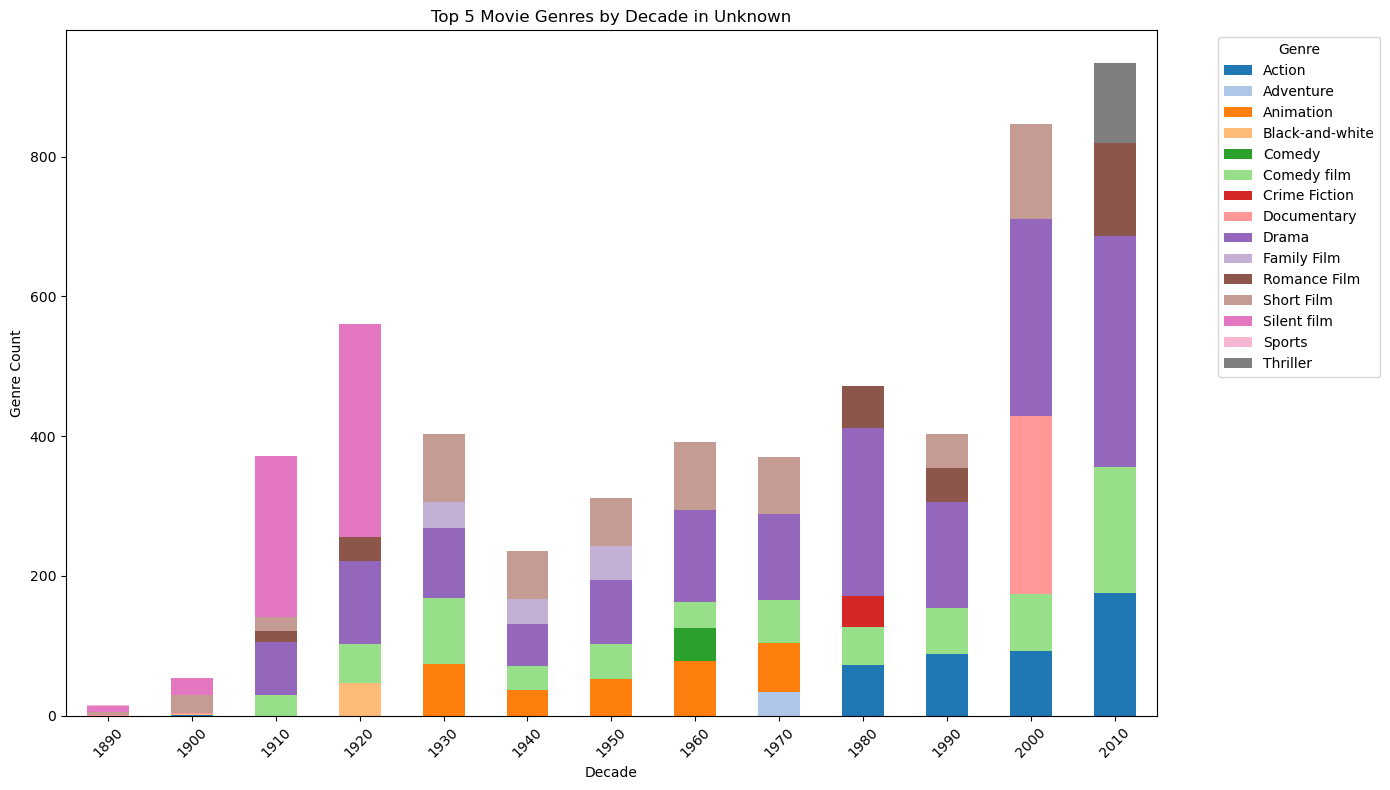

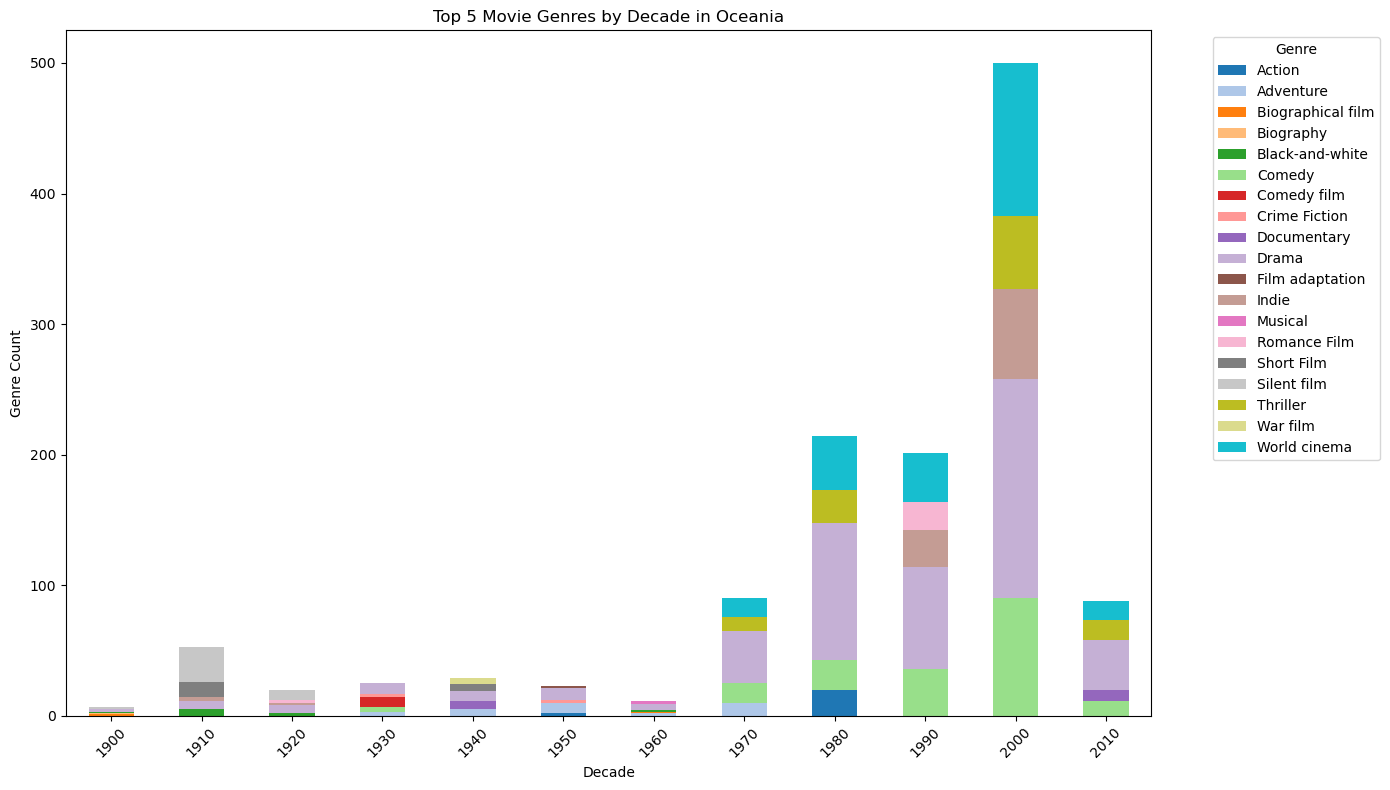

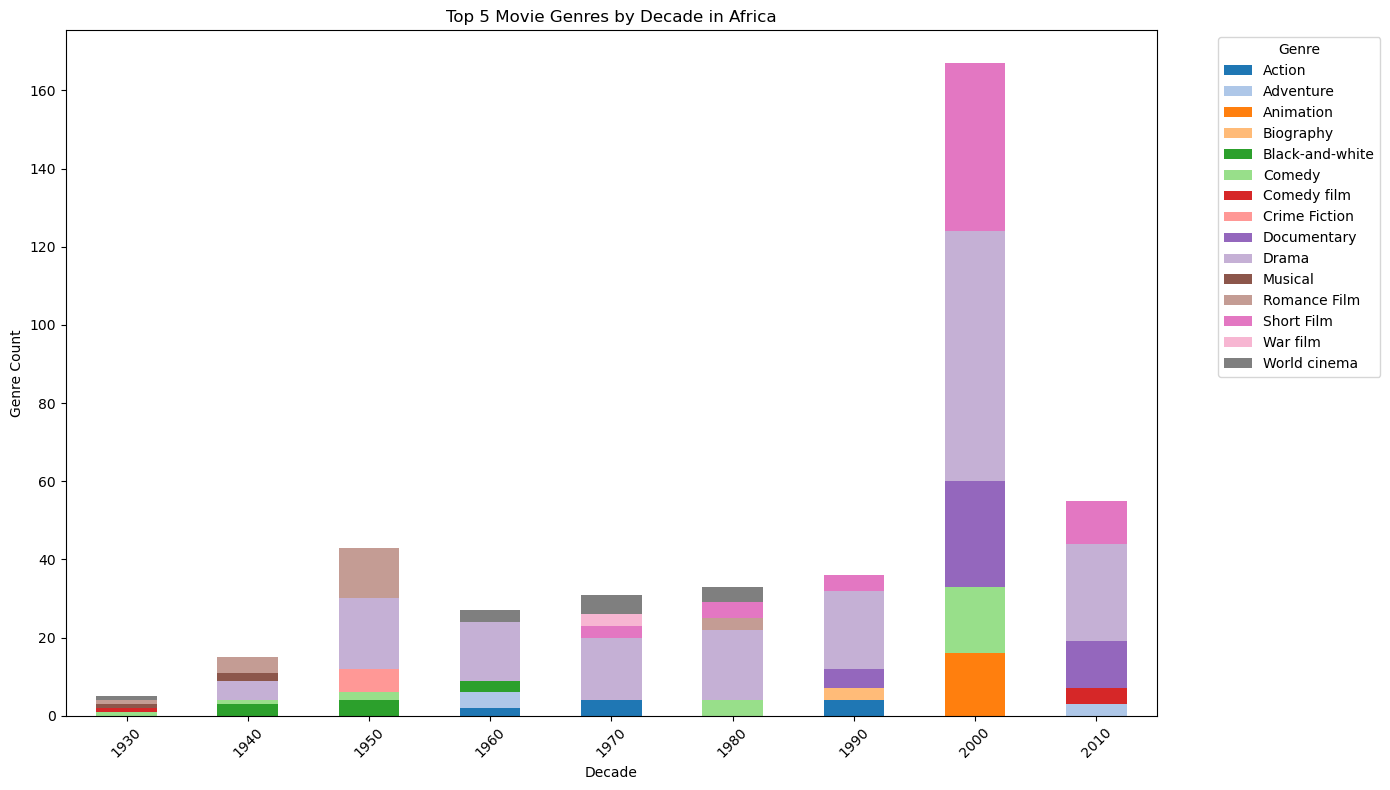

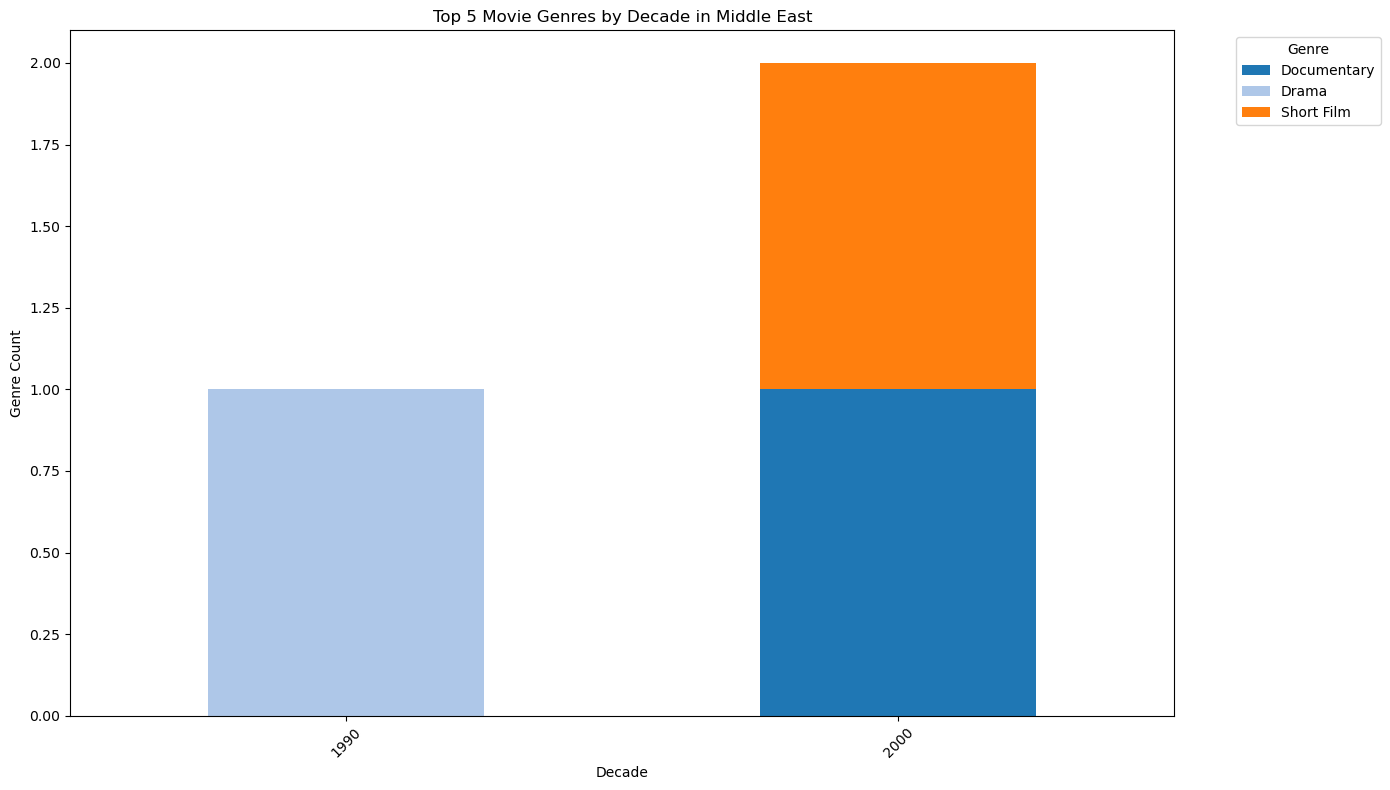

In [10]:
# Count occurence of each genre by grouping by decade, continent and genre
genre_counts = (
    df_metadata_exploded
    .groupby(['Decade', 'Movie_continent', 'Movie_genres'])
    .size()
    .reset_index(name='Count')
)

# Find the top 5 genres per decade and continent
top_genres = (
    genre_counts
    .sort_values(['Decade', 'Movie_continent', 'Count'], ascending=[True, True, False])
    .groupby(['Decade', 'Movie_continent'])
    .head(5)
)

# Pivot the data for plotting: decade as index continents and genres as columns
top_genres_pivot = top_genres.pivot_table(
    index=['Decade', 'Movie_continent'], 
    columns='Movie_genres', 
    values='Count', 
    fill_value=0
)

# Identify all unique genres across all continents
continents = top_genres['Movie_continent'].unique()

for continent in continents:
    plt.figure(figsize=(14, 8))
    continent_data = top_genres_pivot.xs(continent, level='Movie_continent')
    # Top genres
    unique_top_genres = continent_data.columns[continent_data.sum() > 0].tolist()

    # Color palette
    num_genres = len(unique_top_genres)
    colors = plt.cm.tab20(range(num_genres))
    color_mapping = {genre: colors[i] for i, genre in enumerate(unique_top_genres)}
    assigned_colors = [color_mapping[genre] for genre in unique_top_genres]

    ax = continent_data[unique_top_genres].plot(kind='bar', stacked=True, ax=plt.gca(), color=assigned_colors)
    handles, labels = ax.get_legend_handles_labels()
    filtered_handles = [handle for handle, label in zip(handles, labels) if label in unique_top_genres]
    filtered_labels = [label for label in labels if label in unique_top_genres]

    plt.title(f'Top 5 Movie Genres by Decade in {continent}')
    plt.xlabel('Decade')
    plt.ylabel('Genre Count')
    plt.legend(filtered_handles, filtered_labels, title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Removing the black-and-white genre as it might be relevant for our study?

<Figure size 1400x800 with 0 Axes>

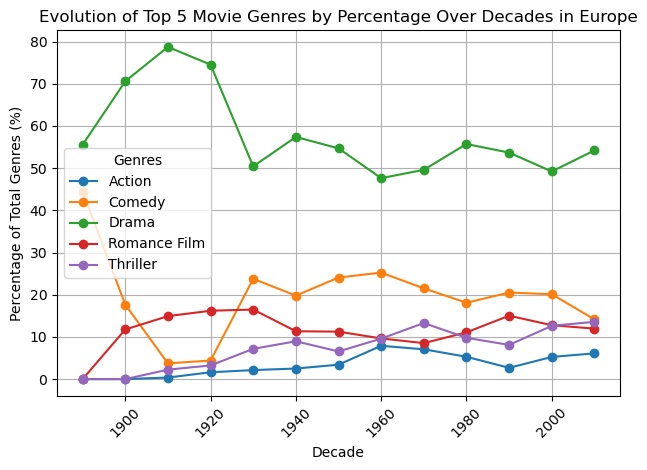

<Figure size 1400x800 with 0 Axes>

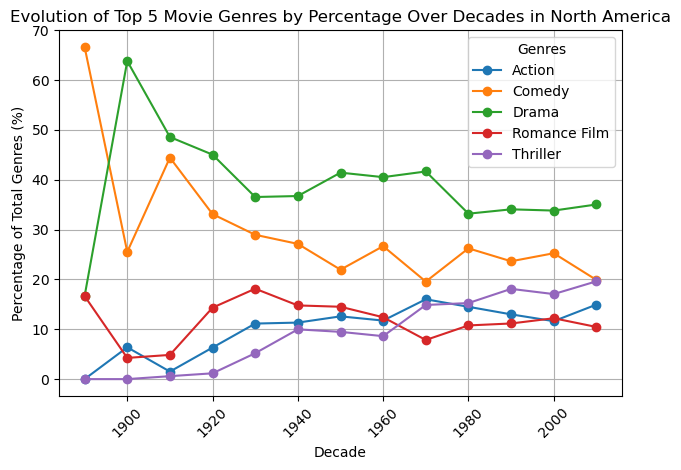

<Figure size 1400x800 with 0 Axes>

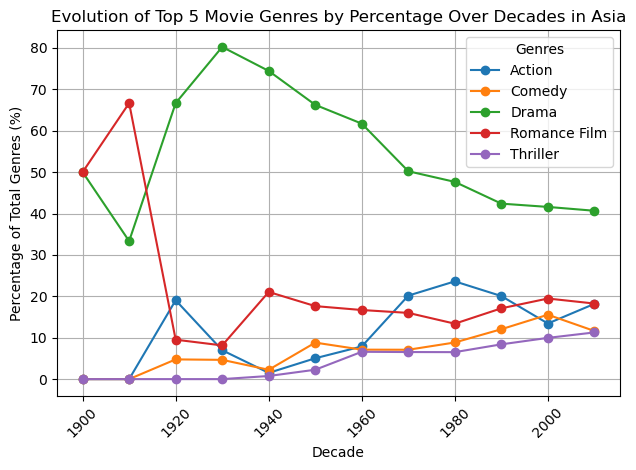

<Figure size 1400x800 with 0 Axes>

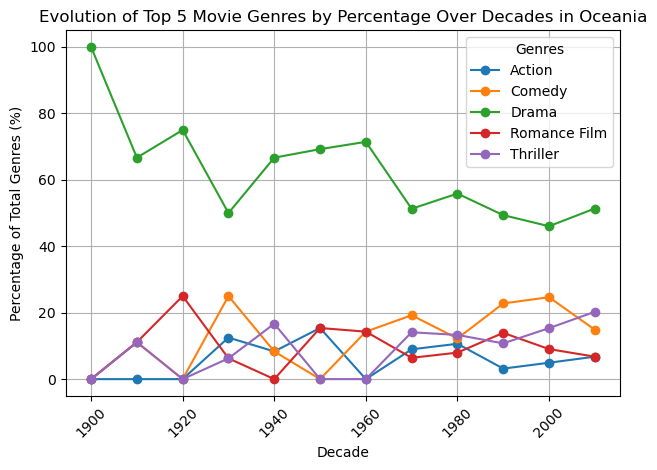

<Figure size 1400x800 with 0 Axes>

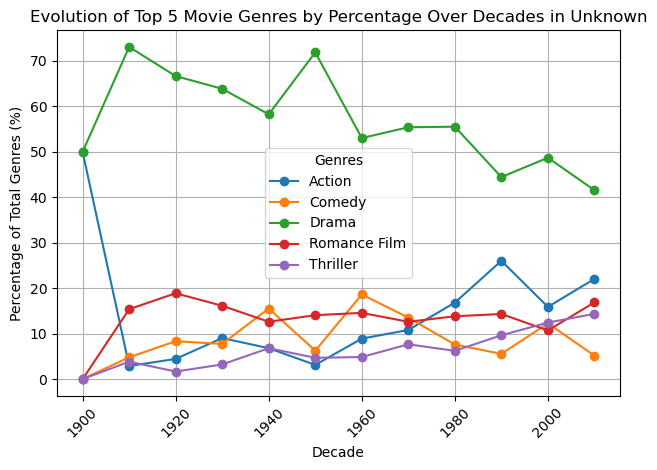

<Figure size 1400x800 with 0 Axes>

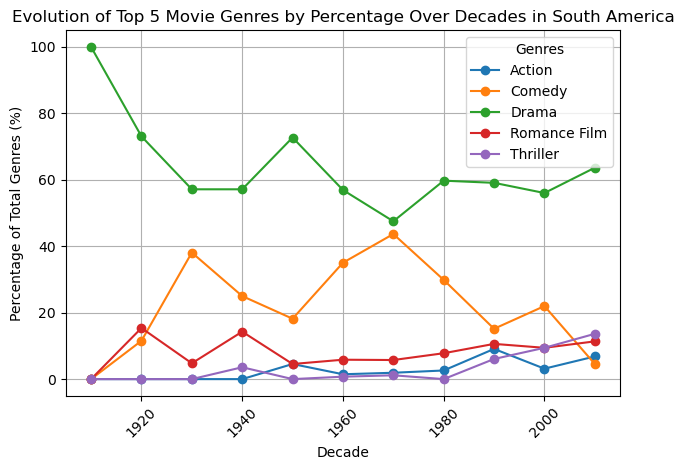

<Figure size 1400x800 with 0 Axes>

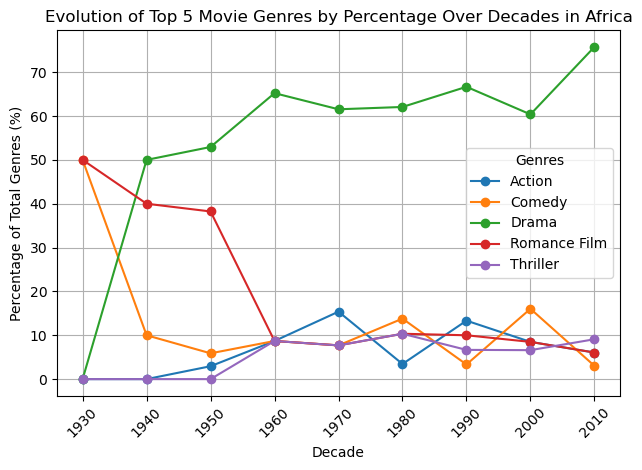

<Figure size 1400x800 with 0 Axes>

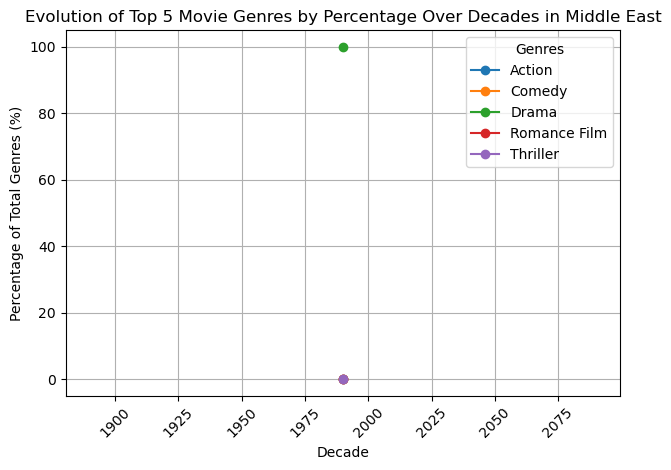

In [11]:
# Remove black-and-white genre
df_metadata_exploded = df_metadata_exploded[~df_metadata_exploded['Movie_genres'].str.contains('Black-and-white', na=False)]
df_metadata_exploded = df_metadata_exploded[df_metadata_exploded['Decade'] >= 1800]

df_metadata_exploded['Movie_genres'] = df_metadata_exploded['Movie_genres'].astype(str)  # Convert all values to string

# Count occurrences of each genre by grouping by decade, continent and genre
overall_genre_counts = (
    df_metadata_exploded
    .groupby(['Decade', 'Movie_continent', 'Movie_genres'])
    .size()
    .reset_index(name='Count')
)

# Overall top 5 genres across all continents
overall_top_genres = (
    overall_genre_counts
    .groupby('Movie_genres')['Count']
    .sum()
    .nlargest(5)
)

top_genre_names = overall_top_genres.index.tolist()

# Keep only top genres and calculate percentages for each continent
top_genre_counts = overall_genre_counts[overall_genre_counts['Movie_genres'].isin(top_genre_names)]

# Calculate total counts per decade and continent
total_counts_per_decade_continent = top_genre_counts.groupby(['Decade', 'Movie_continent'])['Count'].sum().reset_index()
total_counts_per_decade_continent.rename(columns={'Count': 'Total_Count'}, inplace=True)

# Merge to calculate percentage for each continent
top_genre_counts = top_genre_counts.merge(total_counts_per_decade_continent, on=['Decade', 'Movie_continent'])
top_genre_counts['Percentage'] = (top_genre_counts['Count'] / top_genre_counts['Total_Count']) * 100

# Pivot for plotting: decade and continent as indices, genres as columns
top_genre_percentages_pivot = top_genre_counts.pivot_table(
    index=['Decade', 'Movie_continent'],
    columns='Movie_genres',
    values='Percentage',
    fill_value=0
)

continents = top_genre_counts['Movie_continent'].unique()
for continent in continents:
    plt.figure(figsize=(14, 8))
    continent_data = top_genre_percentages_pivot.xs(continent, level='Movie_continent')
    continent_data.plot(kind='line', marker='o')
    
    plt.title(f'Evolution of Top 5 Movie Genres by Percentage Over Decades in {continent}')
    plt.xlabel('Decade')
    plt.ylabel('Percentage of Total Genres (%)')
    plt.legend(title='Genres')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()
